In [41]:
import spotifyapi
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

To use the Spotify API you must have API tokens

Steps to get API access:
1. Log into the dashboard using your Spotify account @ https://developer.spotify.com/
2. Create an app and select "Web API" for the question asking which APIs are you planning to use. Once you have created your app, you will have access to the app credentials (Client ID and Secret). These will be required for API authorization to obtain an access token.
3. Use the access token in your API requests.

In [13]:
#Note that you should not share your Client ID or Secret with Anyone, but for ease of grading yolo.
Client_ID = "080544c4ba6b4712a6e11a98dfc2028a"
Client_Secret = "93e55c34c76e4dc79b3e722cdddcf276"

#Get OAuth 2.0 Tokens, if your ./data/access_token.json file is editted / corrupted / or formatted incorrectly and you are getting errors, just delete the json file and rerun this function.
access_token = spotifyapi.get_access_token(Client_ID, Client_Secret)

Create 3 dataframes from separate endpoints to contain artist metadata, artist and track data for merging, and track metadata.

In [ ]:
#Make a list of artists you want to collect songs for
artist_ids = ['3WrFJ7ztbogyGnTHbHJFl2', '3r9TXuXfOUxXjgYgAR0fP8', '0LcJLqbBmaGUft1e9Mm8HV', '6A43Djmhbe9100UwnI7epV', '1HY2Jd0NmPuamShAr6KMms', '3jOstUTkEu2JkjvRdBA5Gu']
market = 'US'

artist_name = []
artist_id_list = []
track_name = []
track_id_list = []

for artist in artist_ids:
    #sleeping between requests so as to not get timed out by the spotify api. Example should take about 1 minute.
    time.sleep(10)
    response = spotifyapi.get_artist_top_tracks(artist, access_token=access_token, market=market)
    for track in response['tracks']:
        # Extracting the first artist's name
        artist_name_var = track['artists'][0]['name']
        artist_name.append(artist_name_var)

        # Extracting the track name
        track_name_var = track['name']
        track_name.append(track_name_var)

        # Extracting the first artist's id
        artist_id_var = track['artists'][0]['id']
        artist_id_list.append(artist_id_var)

        # Extracting the track id
        track_id_var = track['id']
        track_id_list.append(track_id_var)

track_df = pd.DataFrame({
    'Artist': artist_name,
    'artist_id': artist_id_list,
    'Track Name': track_name,
    'track_id': track_id_list
})

In [18]:
unique_artist_ids = list(set(artist_id_list))
response = spotifyapi.get_artists(unique_artist_ids, access_token)

artist_name_column = []
artist_id_column = []
genres_column = []
followers_column = []
popularity_column = []

# Loop through the 'artists' in the response
for artist in response['artists']:
    # Extracting values for each column
    artist_name_column.append(artist['name'])
    artist_id_column.append(artist['id'])
    genres_column.append(','.join(artist['genres']))
    followers_column.append(artist['followers']['total'])
    popularity_column.append(artist['popularity'])

# Creating a DataFrame
artist_df = pd.DataFrame({
    'artist_name': artist_name_column,
    'artist_id': artist_id_column,
    'genres': genres_column,
    'followers': followers_column,
    'popularity': popularity_column
})

In [ ]:
audio_features = spotifyapi.get_tracks_audio_features(track_id_list, access_token)

rows = []

for i, track_id in enumerate(track_id_list):
    # Create a dictionary for each row
    row_dict = {"track_id": track_id}
    
    # Add key-value pairs for each audio feature
    for feature_key, feature_value in audio_features["audio_features"][i].items():
        row_dict[feature_key] = feature_value
    
    # Append the row dictionary to the list
    rows.append(row_dict)

# Create a DataFrame from the list of rows
audio_features_df = pd.DataFrame(rows)

Combine the dfs into one df

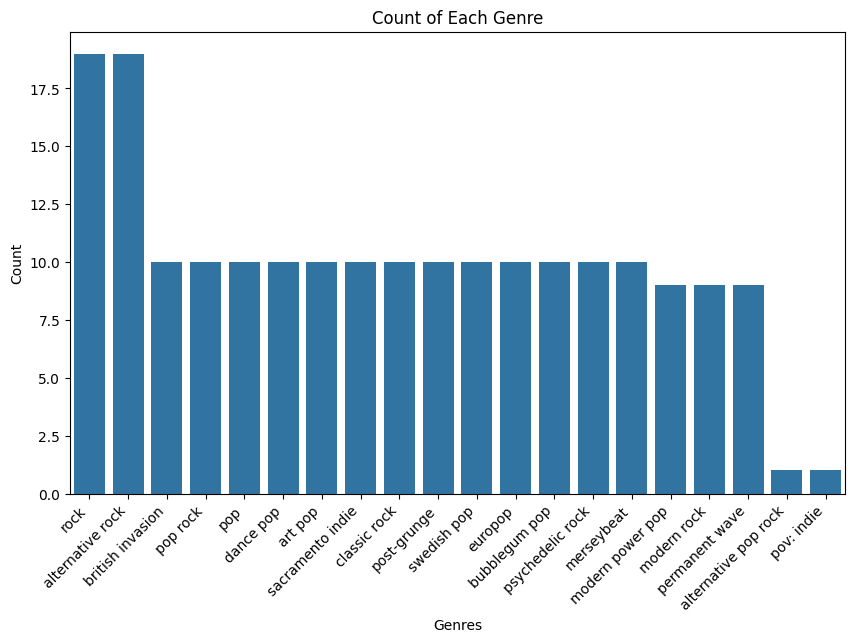

In [45]:
final_df = spotifyapi.join_tables(track_df, artist_df, audio_features_df)

final_df['genres'] = final_df['genres'].str.split(',')
final_df_exploded = final_df.explode('genres')

# Create a countplot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.countplot(data=final_df_exploded, x='genres', order=final_df_exploded['genres'].value_counts().index)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Genres')
plt.ylabel('Count')
plt.title('Count of Each Genre')

# Show the plot
plt.show()